In [1]:
import math
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
from graphviz import Digraph

#construct nodes and edges
def construct(node, nodes, edges):
    if node not in nodes:
        nodes.add(node)
        for child in node.previous:
            edges.add((child, node))
            construct(child, nodes, edges)

#calls construct for the first time
def dfs(root):
    nodes = set()
    edges = set()
    construct(root, nodes, edges)
    return nodes, edges

#constructs the graph
def graph(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = dfs(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.name, n.value, n.grad), shape='record')
        if n.operator:
          dot.node(name = uid + n.operator, label = n.operator)
          dot.edge(uid + n.operator, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

    return dot

In [3]:
class Variable:

    def __init__(self, value, relation=(), operator='', name=''):
        self.value = value
        self.grad = 0.0
        self.previous = set(relation)
        self.operator = operator
        self.name = name
        self.back = lambda: None        # define an empty function for now

    def __repr__(self):
        if(self.name != ''):
            return f"Variable(value={self.value}, name='{self.name}')"
        return f"Variable(value={self.value})"

    def __add__(self, next):
        next = next if isinstance(next, Variable) else Variable(next)
        out = Variable(self.value + next.value, (self, next), '+')

        def back():
            self.grad += 1.0 * out.grad
            next.grad += 1.0 * out.grad
        out.back = back
        return out

    def __sub__(self, next):
        return self + (-next)

    def __rsub__(self, next):
        return next + (-self)

    def __neg__(self):
        return self * -1

    def __radd__(self, next):
        return self + next

    def __truediv__(self, next):
        return self * next**-1

    def __rtruediv(self, next):
        return next * self**-1

    def __pow__(self, next):
        output = Variable(self.value ** next, (self, ), f'**{next}')

        def back():
            self.grad += next * (self.value ** (next - 1)) * output.grad
        output.back = back

        return output

    def __mul__(self, next):
        next = next if isinstance(next, Variable) else Variable(next)
        out = Variable(self.value * next.value, (self, next), '*')

        def back():
            self.grad += next.value * out.grad
            next.grad += self.value * out.grad
        out.back = back
        
        return out

    def log(self):
        epsilon = 1e-7
        if self.value <= 0:
            raise ValueError("Cannot take the logarithm of a non-positive number")
        z = self.value
        out = Variable(math.log(z + epsilon), (self, ), 'log')
    
        def back():
            self.grad += (1/(self.value + epsilon)) * out.grad
    
        out.back = back
    
        return out

    def __rmul__(self, next):
        return self * next

    def sigmoid(self):
        z = self.value
        temp = (1/(1+math.exp(-1*z)))
        output = Variable(temp, (self, ), 'sig')

        def back():
            self.grad += temp * (1 - temp) * output.grad
        output.back = back
        
        return output

    def tanh(self):
        z = self.value
        temp = (math.exp(2*z) - 1)/(math.exp(2*z) + 1)
        output = Variable(temp, (self, ), 'tanh')

        def back():
            self.grad += (1 - temp**2) * output.grad

        output.back = back

        return output

    def exp(self):
        z = self.value
        out = Variable(math.exp(z), (self, ), 'exp')

        def back():
            self.grad += out.value * out.grad

        out.back = back

        return out

    def backward(self):
        def topological_sort(node):
            stack = [node]
            visited = set()
            list_in_order = []
            while stack:
                node = stack[-1]
                if node not in visited:
                    visited.add(node)
                    stack.extend(reversed(list(node.previous)))
                else:
                    list_in_order.append(stack.pop())
            return list_in_order

        list_in_order = []
        list_in_order = topological_sort(self)

        self.grad = 1.0
        list_in_order.reverse()
        for node in list_in_order:
            node.back()


In [4]:
class Neuron:

    def __init__(self, number_of_inputs):
        self.weight = [Variable(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.bias = Variable(random.uniform(-1, 1))

    def __call__(self, input):
        # a = summation (wi*xi) + b
        
        # weighted_input = (inputi*weighti for inputi, weighti in zip(input, self.weight))
        activation = sum((weighti*inputi for inputi, weighti in zip(input, self.weight)), self.bias)
        output = activation.tanh()
        return output

    def definition(self):
        return self.weight + [self.bias]

class Layer:

    def __init__(self, number_of_input, number_of_output):
        self.neurons = [Neuron(number_of_input) for _ in range(number_of_output)]

    def __call__(self, input):
        output = [temp(input) for temp in self.neurons]
        if(len(output) == 1):
            return output[0]
        return output

    def definition(self):
        output = []
        for neuron in self.neurons:
            for temp in neuron.definition():
                output.append(temp)
        return output

class Network:

    def __init__(self, number_of_inputs, number_of_outputs):
        temp = [number_of_inputs] + number_of_outputs
        self.layers = [Layer(temp[i], temp[i+1]) for i in range(len(number_of_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def definition(self):
        output = []
        for layer in self.layers:
            for temp in layer.definition():
                output.append(temp)
        return output

In [5]:
df = pd.read_csv(r"banana.csv")
df

,At1,At2,Class
0,1.140,-0.114,-1
1,-1.520,-1.150,1
2,-1.050,0.720,-1
3,-0.916,0.397,1
4,-1.090,0.437,1
...,...,...,...
5295,0.335,1.390,1
5296,-1.700,-0.569,1
5297,2.640,1.140,1
5298,0.769,0.772,-1


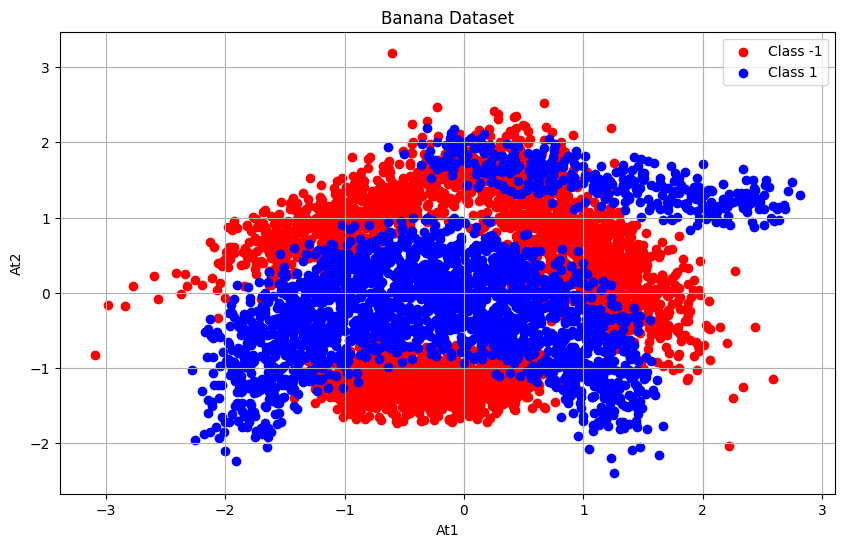

In [6]:
X = df[['At1', 'At2']].values
y = df['Class'].values

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Banana Dataset')
plt.xlabel('At1')
plt.ylabel('At2')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .076)

In [8]:
net = Network(2, [16, 16, 1])

In [9]:
# for temp in y_train:
#     temp = (temp+1)/2

# for iteration in range(20):

#     # forward pass -------------------------------------------------------------
#     y_predictions = [net(temp) for temp in X_train]
#     loss = sum(-y_desired * y_prediction.log() - (1-y_desired) * (1-y_prediction).log() for y_desired, y_prediction in zip(y_train, y_predictions)) / len(X_train)
#     # --------------------------------------------------------------------------

#     # backward pass ------------------------------------------------------------
#     for temp in net.definition():
#         temp.grad = 0.0

#     loss.backward()
#     # --------------------------------------------------------------------------

#     # update -------------------------------------------------------------------
#     for temp in net.definition():
#         temp.value += -0.1 * temp.grad
#     # --------------------------------------------------------------------------

#     print(f"Iteration number {iteration}: {loss.value}")

In [10]:
# list(zip(y_predictions, (y_train+1)/2))

# Consider 40 epochs

In [11]:
losses = []

for iteration in range(80):
    # forward pass -------------------------------------------------------------
    y_predictions = [net(temp) for temp in X_train]
    loss = sum((y_prediction - y_desired)**2 for y_desired, y_prediction in zip(y_train, y_predictions)) / (2*len(X_train))
    # --------------------------------------------------------------------------
    
    # backward pass ------------------------------------------------------------
    for temp in net.definition():
        temp.grad = 0.0
    
    loss.backward()
    # --------------------------------------------------------------------------
    
    # update -------------------------------------------------------------------
    for temp in net.definition():
        temp.value += -0.1 * temp.grad
    # --------------------------------------------------------------------------
    
    # Store loss for plotting
    losses.append(loss.value)
    
    print(f"Iteration number {iteration}: {loss.value}")

Iteration number 0: 0.7371860384396248
Iteration number 1: 0.6924036966088977
Iteration number 2: 0.645363091916898
Iteration number 3: 0.5631625357184983
Iteration number 4: 0.4698499828605577
Iteration number 5: 0.7106071182718934
Iteration number 6: 0.4947651896034934
Iteration number 7: 0.4682705691721935
Iteration number 8: 0.694940039691591
Iteration number 9: 0.4668532865759744
Iteration number 10: 0.35798336989604185
Iteration number 11: 0.49217872788374745
Iteration number 12: 0.4751985667721993
Iteration number 13: 0.5243470995905803
Iteration number 14: 0.3695410587776073
Iteration number 15: 0.3903944136865426
Iteration number 16: 0.3709525898980689
Iteration number 17: 0.36709050491228906
Iteration number 18: 0.3397850029156802
Iteration number 19: 0.3343721715275249
Iteration number 20: 0.3120217501644471
Iteration number 21: 0.30682268868371154
Iteration number 22: 0.29944094386194264
Iteration number 23: 0.30180613968378234
Iteration number 24: 0.2877801302259265
Iterat

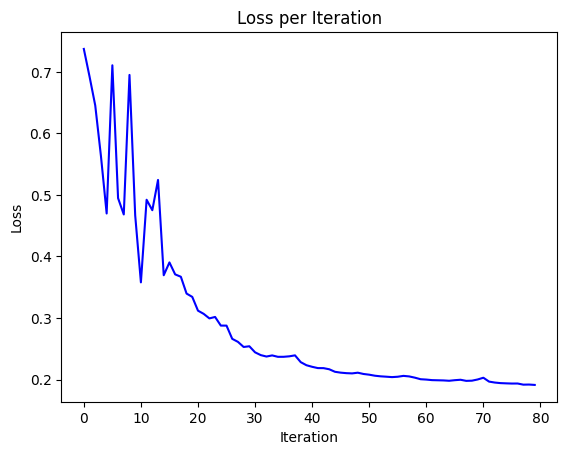

In [12]:
# Plot epoch graph after all iterations
plt.plot(range(80), losses, color='blue')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration')
plt.show()

In [13]:
list(zip(y_predictions, y_train))

[(Variable(value=0.8631846735211482), 1),
 (Variable(value=-0.8961974305302753), -1),
 (Variable(value=0.79578620460795), 1),
 (Variable(value=-0.03797390058522078), -1),
 (Variable(value=-0.620307609160175), -1),
 (Variable(value=0.6087784553750429), 1),
 (Variable(value=0.5109057450534743), 1),
 (Variable(value=0.2625752113034745), 1),
 (Variable(value=0.6431999725797714), 1),
 (Variable(value=0.24986817906493983), 1),
 (Variable(value=-0.07253137313678529), -1),
 (Variable(value=-0.45042599444728615), -1),
 (Variable(value=-0.8387868531424824), -1),
 (Variable(value=0.5495452283351475), 1),
 (Variable(value=-0.4111299426391), -1),
 (Variable(value=0.8222350364855846), 1),
 (Variable(value=-0.5918813959234684), -1),
 (Variable(value=0.6916248282361493), 1),
 (Variable(value=0.8083771213006395), 1),
 (Variable(value=-0.20550014082585255), 1),
 (Variable(value=-0.423117956223357), -1),
 (Variable(value=-0.5150131995917177), -1),
 (Variable(value=0.6294046385886776), 1),
 (Variable(valu

In [14]:
y_test_pred = [net(temp).value for temp in X_test]

In [15]:
def compute_accuracy(y_pred, y_true):
    # Convert the predicted probabilities to 1 or -1 based on a threshold of 0
    predictions = np.where(y_pred > 0.0, 1, -1)
    # Calculate the accuracy as the mean of correct predictions
    accuracy = np.mean(predictions == y_true)
    return accuracy

# Convert y_test_pred to a numpy array if it's not already
y_test_pred = np.array(y_test_pred)

# Compute the test set accuracy
test_accuracy = compute_accuracy(y_test_pred, y_test)

print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 0.8907717435688036


In [16]:
def compute_accuracy(y_pred, y_true):
    # Convert the predicted probabilities to 1 or -1 based on a threshold of 0.3 and -0.3
    predictions = np.where(y_pred > 0.3, 1, np.where(y_pred < -0.3, -1, 0))
    # Calculate the accuracy as the mean of correct predictions
    accuracy = np.mean(predictions == y_true)
    return accuracy

# Convert y_test_pred to a numpy array if it's not already
y_test_pred = np.array(y_test_pred)

# Compute the test set accuracy
test_accuracy = compute_accuracy(y_test_pred, y_test)

print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 0.7603103307472437
